# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint

## Import and define functions

In [1]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
#sns.set_style("ticks")
plt.style.use("huddlej")

In [3]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [4]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None):
    g = sns.FacetGrid(data, col=predictors_column, col_wrap=4, hue=hue, height=4)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc")

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings

In [5]:
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi-delta_frequency",
    "lbi-dms_star",
    "lbi-ep_x-ne_star"
]

predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "lbi-ep_x"
]

In [6]:
data_root = "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/"

## Load data

In [7]:
tip_attributes_df = pd.read_table(data_root + "standardized_tip_attributes.tsv", parse_dates=["timepoint"])

In [8]:
tips_to_clades_df = pd.read_table(data_root + "tips_to_clades.tsv", parse_dates=["timepoint"])

In [9]:
model_jsons = glob.glob(data_root + "models/*.json")

In [10]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [11]:
models_by_predictors["lbi"]["cost_function"]

'information_gain'

In [12]:
models_by_predictors["lbi"]["l1_lambda"]

0.0

In [13]:
models_by_predictors["lbi"]["training_window"]

6

In [14]:
models_by_predictors.keys()

dict_keys(['lbi', 'lbi-ep_x', 'delta_frequency', 'ep_x', 'naive'])

In [15]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [16]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [17]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

64

In [18]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [19]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[0.8209057795018139]

In [20]:
len(models_by_predictors["lbi"]["scores"])

7

Build data frames for plotting from the model scores.

In [21]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient in zip(model["predictors"], scores["coefficients"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])
        y_init = X.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()
        
        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        frequency_df = frequency_df.merge(y_init, on=["timepoint", "clade_membership"], suffixes=["", "_init"])
        frequency_df["residual"] = frequency_df["frequency"] - frequency_df["frequency_hat"]
        frequency_df["observed_growth_rate"] = frequency_df["frequency"] / frequency_df["frequency_init"]
        frequency_df["predicted_growth_rate"] = frequency_df["frequency_hat"] / frequency_df["frequency_init"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)
        
        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y.merge(training_y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        residual_df["residual"] = residual_df["frequency"] - residual_df["frequency_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors
        residuals_dfs.append(residual_df)

overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [22]:
training_y.head()

,clade_membership,frequency,timepoint
0,050242e,0.010580,2007-10-01
1,1518fdb,0.000000,2007-10-01
2,2bc0250,0.009099,2007-10-01
3,3c0baec,0.000000,2007-10-01
4,5eafe23,0.000000,2007-10-01


In [23]:
training_y_hat.head()

,clade_membership,frequency,timepoint
0,050242e,0.094635,2007-10-01
1,1518fdb,0.026757,2007-10-01
2,2bc0250,0.064256,2007-10-01
3,3c0baec,0.005598,2007-10-01
4,5eafe23,0.008566,2007-10-01


In [24]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,06ed3c7,0.014498,2004-10-01,0.187362,-0.172864,2011-10-01,lbi
1,31e4ba2,0.000000,2004-10-01,0.014563,-0.014563,2011-10-01,lbi
2,412c00a,0.000000,2004-10-01,0.000316,-0.000316,2011-10-01,lbi
3,44989e1,0.045966,2004-10-01,0.192496,-0.146530,2011-10-01,lbi
4,4ff1302,0.010252,2004-10-01,0.060483,-0.050231,2011-10-01,lbi


In [25]:
residual_df.shape

(6390, 7)

In [26]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,026d21f,0.003038,2011-10-01,0.000327,0.001722,0.002711,1.764228,0.190037,2011-10-01,lbi
1,05daa66,0.000000,2011-10-01,0.001647,0.005476,-0.001647,0.000000,0.300748,2011-10-01,lbi
2,15db5d7,0.000000,2011-10-01,0.002696,0.015034,-0.002696,0.000000,0.179337,2011-10-01,lbi
3,1f55924,0.000000,2011-10-01,0.000468,0.002684,-0.000468,0.000000,0.174494,2011-10-01,lbi
4,24fc224,0.000000,2011-10-01,0.000712,0.004075,-0.000712,0.000000,0.174784,2011-10-01,lbi


In [27]:
overall_errors_df.sort_values("cv_error_mean")

,cv_error_mean,cv_error_std,predictors
0,-0.256925,0.231849,lbi
2,-0.144913,0.206004,delta_frequency
1,-0.109803,0.276256,lbi-ep_x
4,0.000002,0.000009,naive
3,0.031595,0.090454,ep_x


In [28]:
errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint
0,lbi,-0.294302,24,2011-10-01
1,lbi,-0.072552,20,2012-04-01
2,lbi,-0.602656,23,2012-10-01
3,lbi,-0.425378,20,2013-04-01
4,lbi,0.146422,19,2013-10-01


In [29]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,026d21f,0.003038,2011-10-01,0.000327,0.001722,0.002711,1.764228,0.190037,2011-10-01,lbi
1,05daa66,0.000000,2011-10-01,0.001647,0.005476,-0.001647,0.000000,0.300748,2011-10-01,lbi
2,15db5d7,0.000000,2011-10-01,0.002696,0.015034,-0.002696,0.000000,0.179337,2011-10-01,lbi
3,1f55924,0.000000,2011-10-01,0.000468,0.002684,-0.000468,0.000000,0.174494,2011-10-01,lbi
4,24fc224,0.000000,2011-10-01,0.000712,0.004075,-0.000712,0.000000,0.174784,2011-10-01,lbi


## Summarize future frequencies per timepoint

In [30]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum() > 0.9999).sum()

35

In [31]:
frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum().shape

(35,)

In [32]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency"].sum() > 0.9999).sum()

25

In [33]:
frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum()

timepoint
2011-10-01    0.989569
2012-04-01    1.000002
2012-10-01    1.000002
2013-04-01    1.000009
2013-10-01    0.999999
2014-04-01    1.000004
2014-10-01    0.996891
Name: frequency, dtype: float64

(0.98, 1.01)

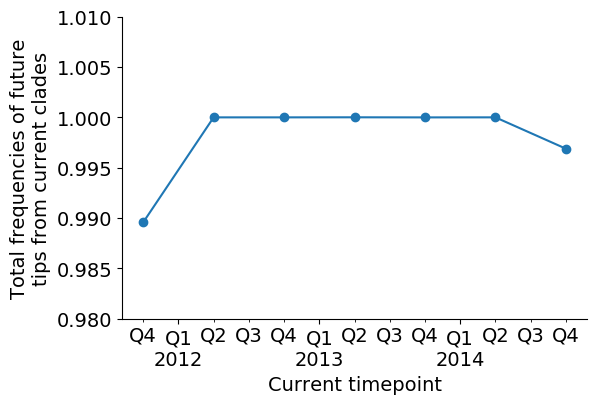

In [34]:
ax = frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum().plot(marker="o")
ax.set_xlabel("Current timepoint")
ax.set_ylabel("Total frequencies of future\ntips from current clades")
ax.set_ylim(0.98, 1.01)

## Inspect clade linkage between timepoints

Find out which clades assigned to tips per timepoint are present in the final timepoint.

In [35]:
tip_attributes_df.loc[:, ["strain", "timepoint", "clade_membership"]].head()

,strain,timepoint,clade_membership
0,A/BacGiang/BG003/2004,2004-10-01,4ff1302
1,A/California/7/2004,2004-10-01,7aa732d
2,A/California/NHRC0002/2003,2004-10-01,4ff1302
3,A/Canterbury/100/2004,2004-10-01,7aa732d
4,A/Canterbury/20/2004,2004-10-01,7aa732d


In [36]:
tips_to_clades_df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Canterbury/99/2000,9d101b5,0,h3n2,ha,2004-10-01
1,A/Canterbury/99/2000,2f661b6,2,h3n2,ha,2004-10-01
2,A/Canterbury/99/2000,root,3,h3n2,ha,2004-10-01
3,A/Canterbury/96/2000,9d101b5,0,h3n2,ha,2004-10-01
4,A/Canterbury/96/2000,2f661b6,2,h3n2,ha,2004-10-01


In [37]:
clades_per_timepoint = tip_attributes_df.loc[:, ["timepoint", "clade_membership"]].drop_duplicates()

In [38]:
clades_per_timepoint.head()

,timepoint,clade_membership
0,2004-10-01,4ff1302
1,2004-10-01,7aa732d
11,2004-10-01,b32cea9
12,2004-10-01,972df4f
14,2004-10-01,962ced9


In [39]:
clades_per_timepoint.tail()

,timepoint,clade_membership
5501,2015-10-01,549e639
5545,2015-10-01,6eae31c
5587,2015-10-01,e4d8ffe
5661,2015-10-01,0742507
5674,2015-10-01,f4c6fd2


In [40]:
tips_to_clades_df.tail()

,tip,clade_membership,depth,lineage,segment,timepoint
753381,A/Rondonia/18925/2015,4e35443,162,h3n2,ha,2015-10-01
753382,A/Rondonia/18925/2015,9a3ff5d,163,h3n2,ha,2015-10-01
753383,A/Rondonia/18925/2015,a5bcb4f,164,h3n2,ha,2015-10-01
753384,A/Rondonia/18925/2015,1c5e069,166,h3n2,ha,2015-10-01
753385,A/Rondonia/18925/2015,root,167,h3n2,ha,2015-10-01


In [41]:
tips_to_clades_df["timepoint"].max()

Timestamp('2015-10-01 00:00:00')

In [42]:
clades_present_at_last_timepoint = set(tips_to_clades_df.loc[
    tips_to_clades_df["timepoint"] == tips_to_clades_df["timepoint"].max(),
    "clade_membership"
].drop_duplicates().values)

In [43]:
list(clades_present_at_last_timepoint)[:5]

['c17559e', '7fa06b5', '819ddab', 'd1cce86', '048f8ca']

In [44]:
len(clades_present_at_last_timepoint)

166

In [45]:
clades_per_timepoint["present_at_last_timepoint"] = clades_per_timepoint["clade_membership"].apply(
    lambda clade: clade in clades_present_at_last_timepoint
)

In [46]:
clades_per_timepoint.head()

,timepoint,clade_membership,present_at_last_timepoint
0,2004-10-01,4ff1302,True
1,2004-10-01,7aa732d,True
11,2004-10-01,b32cea9,False
12,2004-10-01,972df4f,True
14,2004-10-01,962ced9,True


Text(0,0.5,'Number of clades')

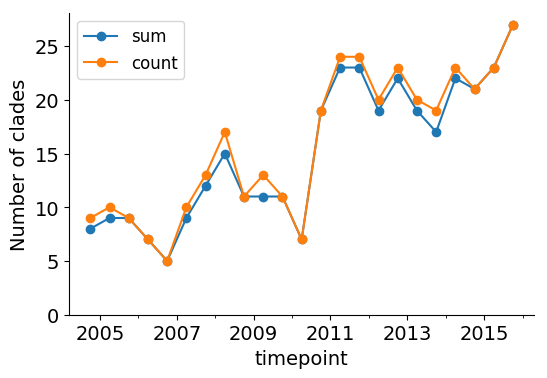

In [47]:
ax = clades_per_timepoint.groupby("timepoint")["present_at_last_timepoint"].aggregate(["sum", "count"]).plot(marker="o")
ax.set_ylim(bottom=0)
ax.set_ylabel("Number of clades")

In [48]:
counts_of_clades_per_timepoint = clades_per_timepoint.groupby("timepoint")["present_at_last_timepoint"].aggregate(["sum", "count"])

In [49]:
counts_of_clades_per_timepoint["missing"] = counts_of_clades_per_timepoint["count"] - counts_of_clades_per_timepoint["sum"]

Text(0,0.5,'Clades missing from final timepoint')

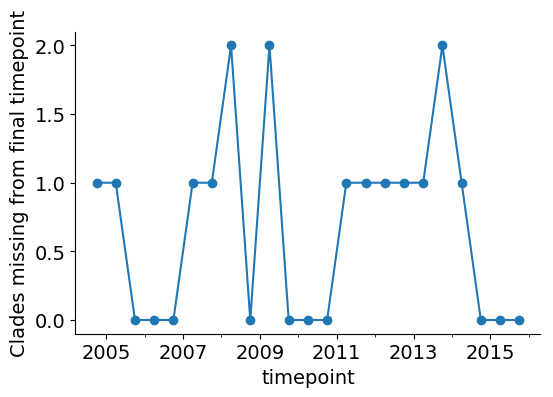

In [50]:
ax = counts_of_clades_per_timepoint["missing"].plot(marker="o")
ax.set_ylabel("Clades missing from final timepoint")

In [51]:
clades_per_timepoint[~clades_per_timepoint["present_at_last_timepoint"]].head()

,timepoint,clade_membership,present_at_last_timepoint
11,2004-10-01,b32cea9,False
121,2005-04-01,b32cea9,False
500,2007-04-01,74a2c50,False
696,2007-10-01,8dd9dae,False
872,2008-04-01,8dd9dae,False


In [52]:
tip_attributes_df[(tip_attributes_df["timepoint"] == "2004-10-01") & (tip_attributes_df["clade_membership"] == "42c20f9")]

,strain,branch_length,cTiter,cTiterSub,cTiterSub_x,clade_membership,clock_length,country,country_entropy,dTiter,...,rb,region,region_entropy,is_terminal,timepoint,lineage,segment,frequency,naive,intercept


In [53]:
tips_to_clades_df[(tips_to_clades_df["tip"] == "A/Austria/144219/2004") & (tips_to_clades_df["depth"] == 0)]

,tip,clade_membership,depth,lineage,segment,timepoint


In [54]:
timepoints = tip_attributes_df["timepoint"].drop_duplicates()

In [55]:
# Get sequence for above strain from all amino acid translations per timepoint.
strain = "A/Austria/144219/2004"
strain_sequences = []
genes = ["SigPep", "HA1", "HA2"]

for timepoint in timepoints:
    sequence = ""
    for gene in genes:
        alignment_name = data_root + "timepoints/%s/segments/ha/aa-seq_%s.fasta" % (timepoint.strftime("%Y-%m-%d"), gene)
        with open(alignment_name, "r") as fh:
            records = Bio.SeqIO.parse(fh, "fasta")
            for record in records:
                if record.id == strain:
                    sequence += str(record.seq)
                    break

    if len(sequence) > 0:
        strain_sequences.append(sequence)

In [56]:
len(strain_sequences)

0

In [57]:
if len(strain_sequences) > 0:
    for i in range(len(strain_sequences[0])):
        bases = set([sequence[i] for sequence in strain_sequences])
        if len(bases) != 1:
            print("%i: %s" % (i, bases))

In [60]:
strain_nucleotide_sequences = []
if len(strain_sequences) > 0:
    for timepoint in timepoints:
        json_name = data_root + "timepoints/%s/segments/ha/nt_muts.json" % timepoint.strftime("%Y-%m-%d")
        with open(json_name, "r") as fh:
            nt_muts = json.load(fh)
            strain_nucleotide_sequences.append(nt_muts["nodes"][strain]["sequence"])

In [61]:
len(strain_nucleotide_sequences)

0

In [62]:
len(set(strain_nucleotide_sequences))

0

In [63]:
if len(strain_nucleotide_sequences) > 0:
    for i in range(len(strain_nucleotide_sequences[0])):
        bases = set([sequence[i] for sequence in strain_nucleotide_sequences])
        if len(bases) != 1:
            print("%i: %s" % (i, bases))

In [64]:
strain

'A/Austria/144219/2004'

## Summarize standardized predictor distributions

In [65]:
tip_attributes_df.shape

(5822, 32)

In [66]:
tip_attributes_df["ep_x"].head()

0    2.115938
1    2.780779
2    2.139431
3    2.300266
4    2.300266
Name: ep_x, dtype: float64

In [67]:
tip_attributes_df["ep_x"].dropna().shape

(5822,)

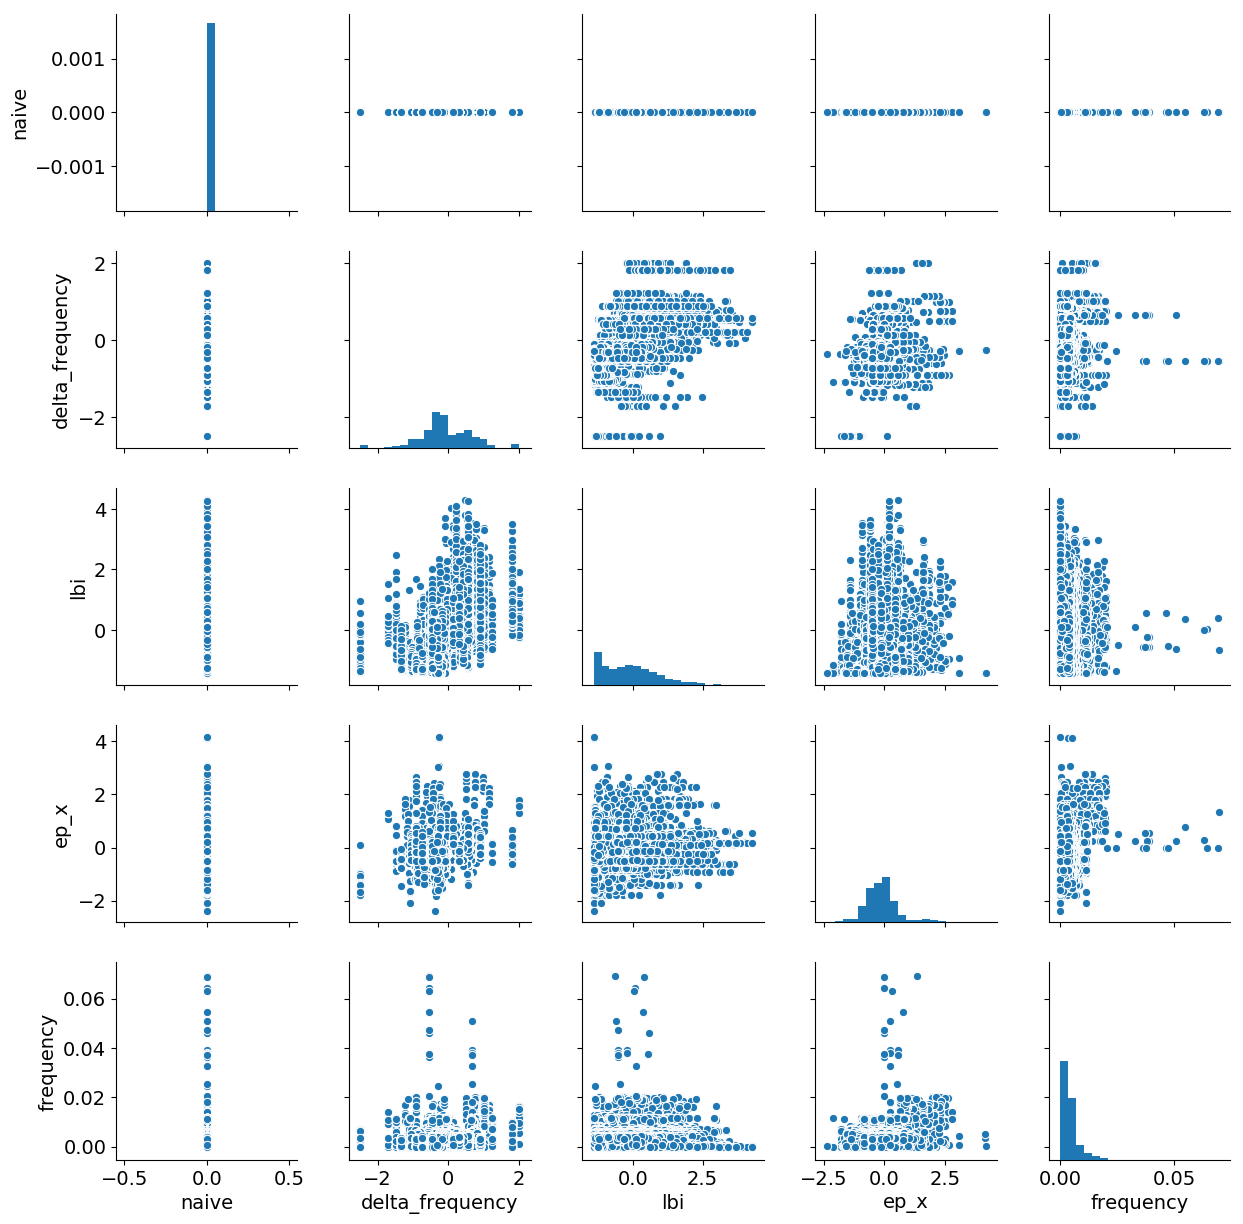

In [68]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df, vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

In [69]:
tip_attributes_df.loc[pd.isnull(tip_attributes_df["ep_x"]), ["strain", "timepoint", "frequency"]]

,strain,timepoint,frequency


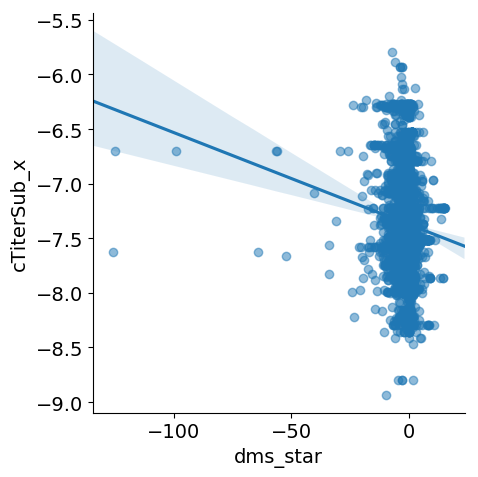

In [70]:
sns.lmplot("dms_star", "cTiterSub_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

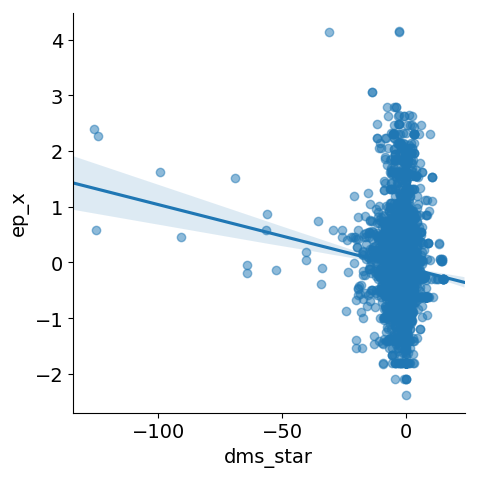

In [71]:
sns.lmplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

In [72]:
tip_attributes_df.loc[tip_attributes_df["dms_star"] < -15, ["timepoint", "strain", "cTiterSub_x", "ep_x", "dms_star", "frequency", "raw_date"]].head()

,timepoint,strain,cTiterSub_x,ep_x,dms_star,frequency,raw_date
345,2006-04-01,A/Hiroshima/52/2005,-7.973330,1.192477,-21.00,0.015206,2005-10-24
493,2007-04-01,A/Canada/19/2006,-7.219742,1.247069,-15.15,0.011657,2006-12-19
561,2007-04-01,A/Malaysia/1681079/2006,-7.220645,-0.583579,-15.44,0.011273,2006-11-24
746,2007-10-01,A/Singapore/139N/2007,-7.520571,-0.219572,-16.50,0.009538,2007-08-10
901,2008-04-01,A/Novosibirsk/1/2008,-7.695290,0.813034,-19.30,0.010833,2008-02-13
906,2008-04-01,A/Peru/WRAIR1508P/2007,-7.382739,0.074473,-15.07,0.000016,2007-XX-XX
914,2008-04-01,A/Singapore/139N/2007,NaN,-0.544271,-16.50,0.000506,2007-08-10
948,2008-04-01,A/Uruguay/723/2007,NaN,-0.891710,-18.28,0.000002,2007-06-15
1054,2008-10-01,A/Novosibirsk/1/2008,NaN,0.580739,-19.30,0.000618,2008-02-13
1179,2009-04-01,A/Kenya/1/2008,NaN,-0.682584,-20.29,0.000012,2008-XX-XX


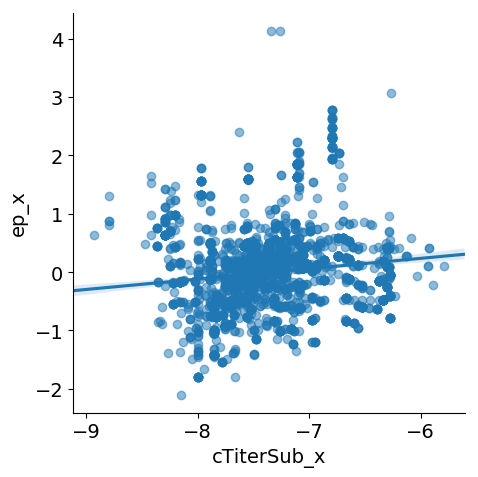

In [73]:
sns.lmplot("cTiterSub_x", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

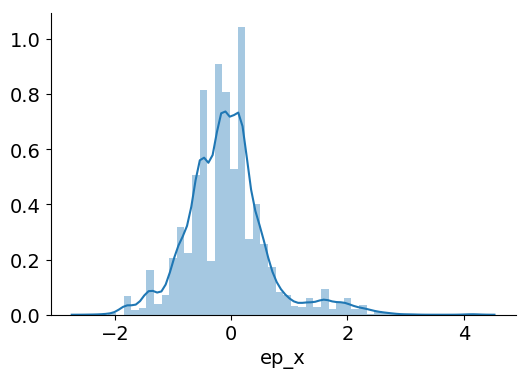

In [74]:
sns.distplot(tip_attributes_df["ep_x"])

In [75]:
tip_attributes_df["ep_x"].mean()

-0.0752268550459381

In [76]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

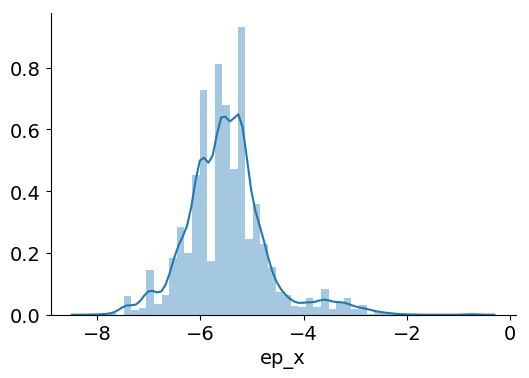

In [77]:
sns.distplot(raw_tip_attributes_df["ep_x"].dropna())

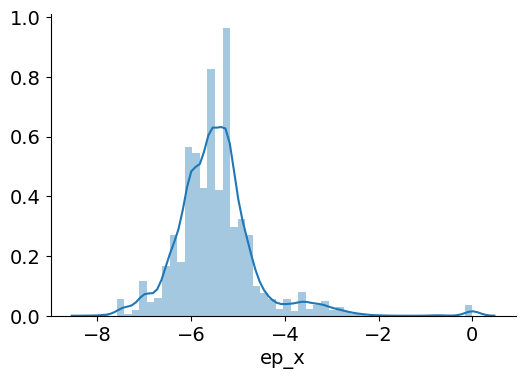

In [78]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(0.0))

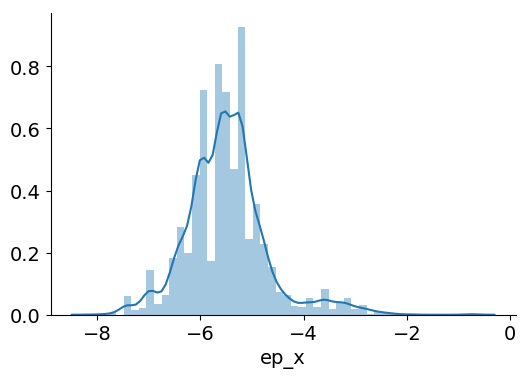

In [79]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(raw_tip_attributes_df["ep_x"].dropna().mean()))

In [80]:
raw_tip_attributes_df["ep_x"].dropna().mean()

-5.488864858911045

In [81]:
raw_tip_attributes_df["ep_x"].dropna().std()

0.7880099011274209

In [82]:
raw_tip_attributes_df["ep_x"].fillna(0.0).mean()

-5.45681034066938

In [83]:
raw_tip_attributes_df["ep_x"].fillna(0.0).std()

0.8901000528277964

## Summarize model residuals

In [84]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [85]:
residuals_by_timepoint.head()

,predictors,timepoint,residual
0,delta_frequency,2004-10-01,-0.000003
1,delta_frequency,2005-04-01,-0.000012
2,delta_frequency,2005-10-01,-0.000009
3,delta_frequency,2006-04-01,0.000012
4,delta_frequency,2006-10-01,-0.000020


In [86]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
delta_frequency   -0.126568
ep_x              -0.126568
lbi               -0.126568
lbi-ep_x          -0.126568
naive             -0.126568
Name: residual, dtype: float64

In [87]:
model_name = "lbi"

In [88]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [89]:
max_lags = 18

Text(0,0.5,'Number of clades')

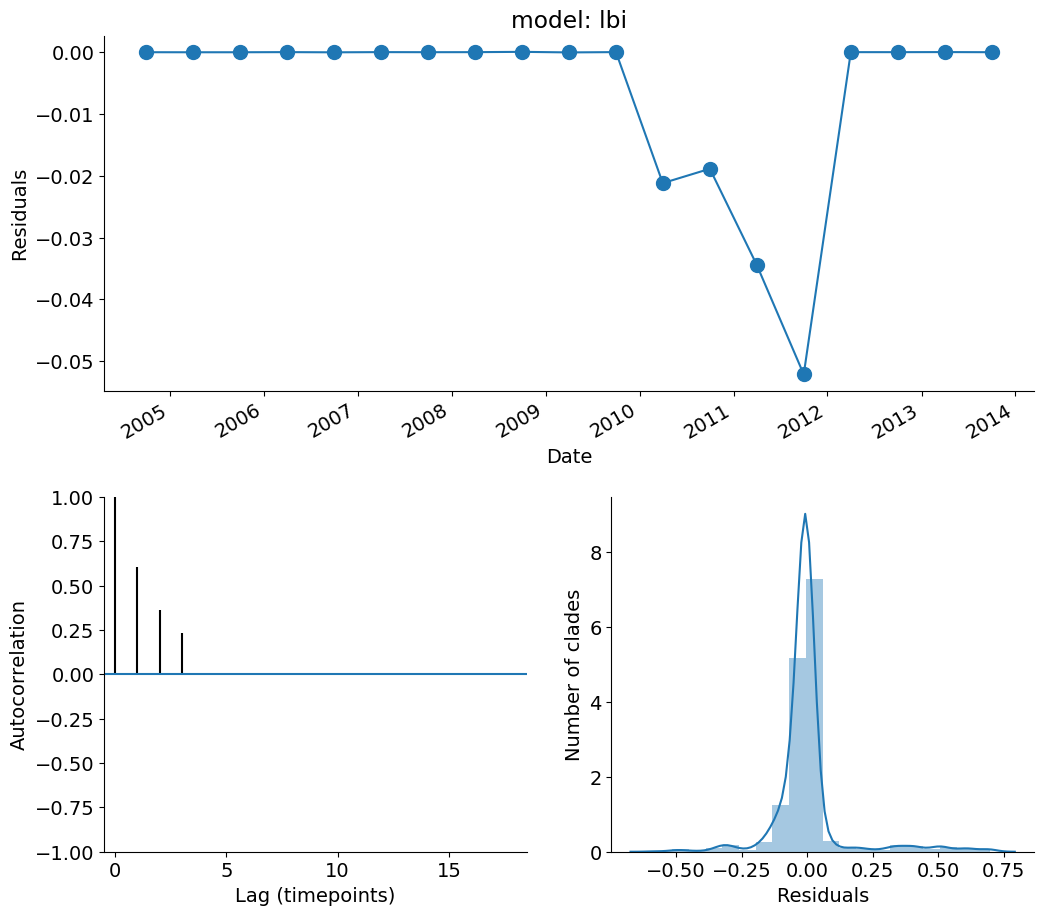

In [90]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [91]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,06ed3c7,0.014498,2004-10-01,0.187362,-0.172864,2011-10-01,lbi
1,31e4ba2,0.000000,2004-10-01,0.014563,-0.014563,2011-10-01,lbi
2,412c00a,0.000000,2004-10-01,0.000316,-0.000316,2011-10-01,lbi
3,44989e1,0.045966,2004-10-01,0.192496,-0.146530,2011-10-01,lbi
4,4ff1302,0.010252,2004-10-01,0.060483,-0.050231,2011-10-01,lbi


### Residuals by predictor

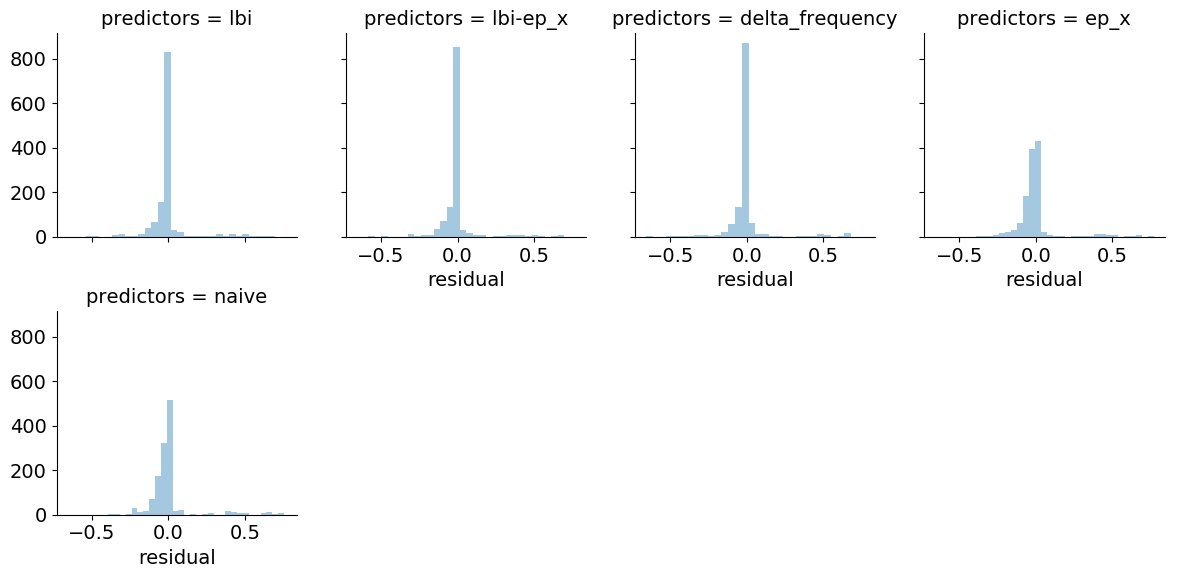

In [92]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=30, kde=False)

In [93]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive             -0.010580
ep_x              -0.010221
delta_frequency   -0.004161
lbi               -0.003576
lbi-ep_x          -0.003343
Name: residual, dtype: float64

In [94]:
residual_df.groupby("predictors")["residual"].count()

predictors
delta_frequency    1278
ep_x               1278
lbi                1278
lbi-ep_x           1278
naive              1278
Name: residual, dtype: int64

In [95]:
(residual_df["residual"] < -0.01).sum()

2656

### Residuals by timepoint

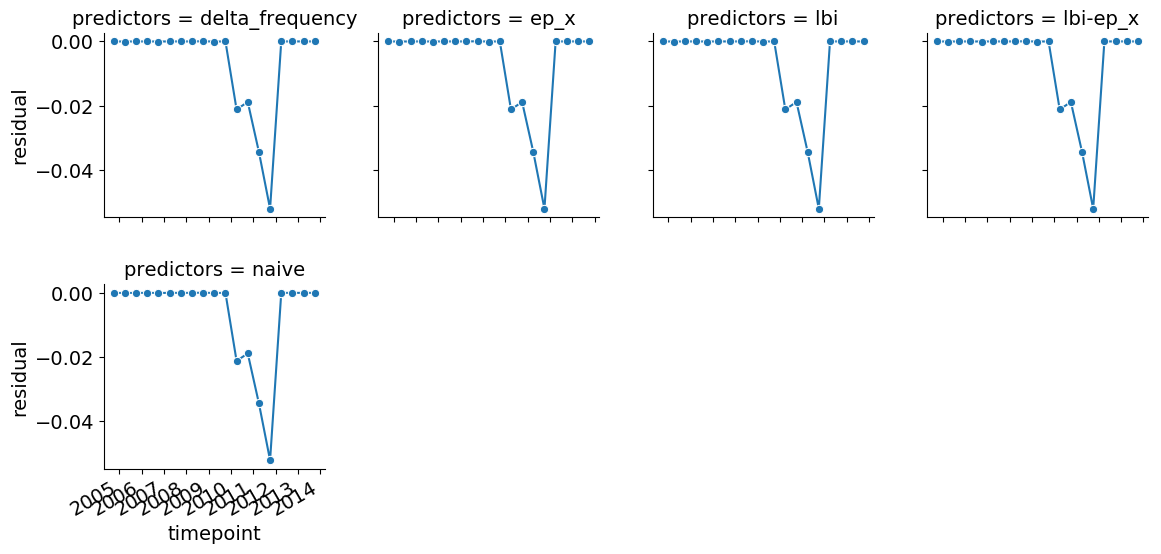

In [96]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [97]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([3.18999384e-16, 2.35293894e-16, 2.25514052e-17, 9.58698995e-16,
       5.55111512e-16, 6.93889390e-16, 2.42861287e-16, 1.89084859e-16,
       2.93515212e-15, 1.34441069e-16, 3.60822483e-16, 3.88578059e-16,
       1.14491749e-16, 1.88044025e-15, 9.36750677e-16, 2.98372438e-16,
       4.16333634e-16, 3.82723367e-16, 2.91868919e-16])

### Autocorrelation of residuals

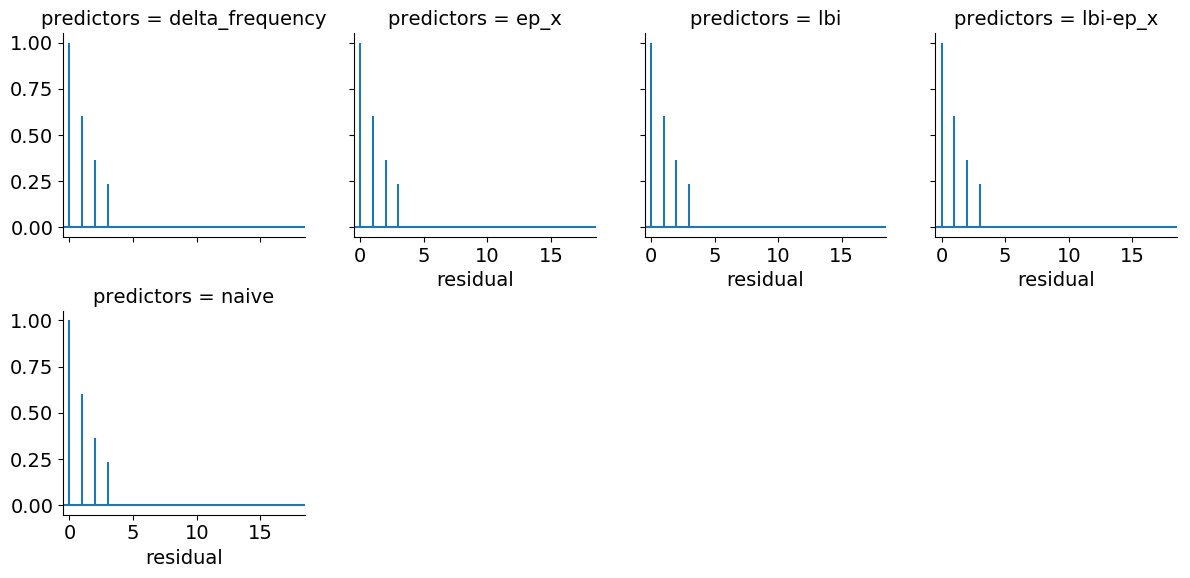

In [98]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted frequencies and growth rates

### Observed and predicted frequencies

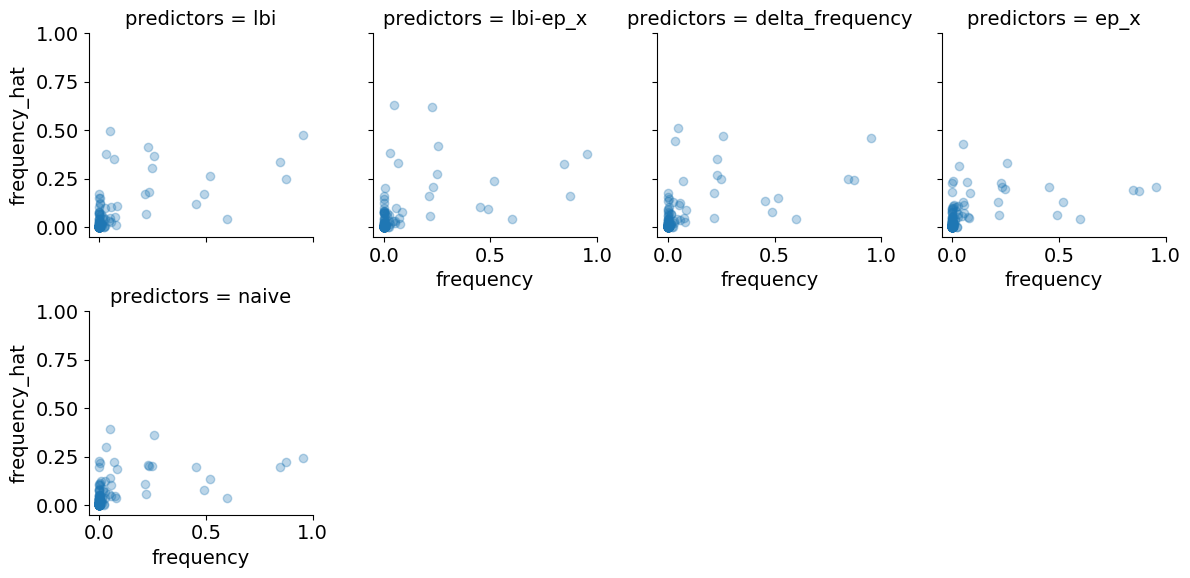

In [99]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

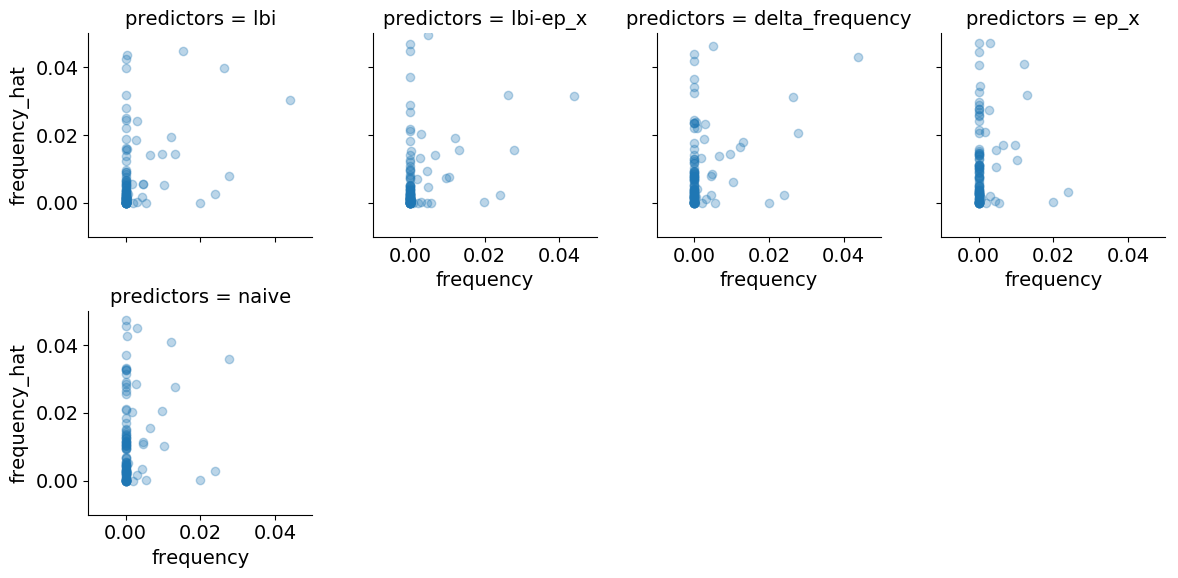

In [100]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.05)
    ax.set_ylim(-0.01, 0.05)

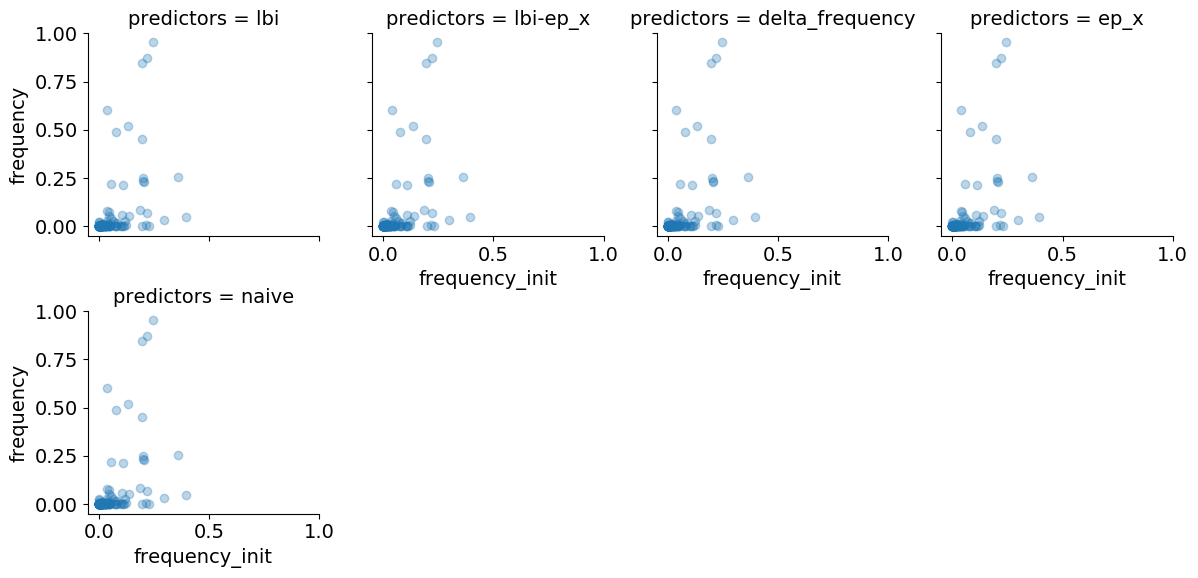

In [101]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

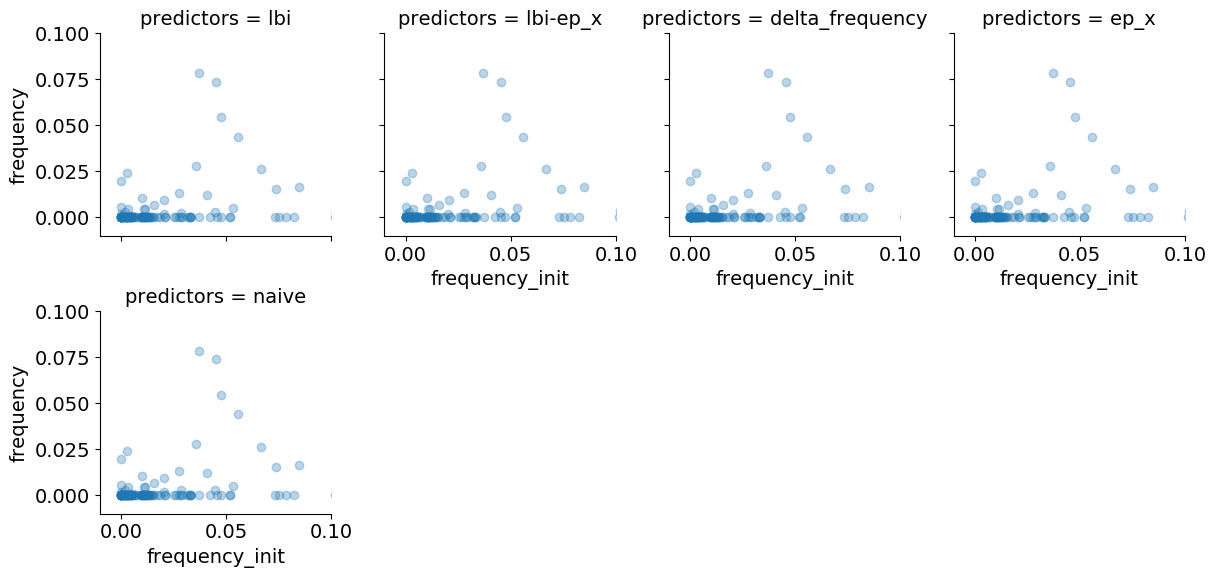

In [102]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.1)
    ax.set_ylim(-0.01, 0.1)

In [103]:
frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

(150,)

In [104]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency"] == 0.0).sum()

86

In [105]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum()

60

In [106]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.4])

In [107]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum()

112

In [108]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.74666667])

### Observed and predicted growth rates

In [109]:
frequency_df[frequency_df["predictors"] == "lbi"].shape

(150, 10)

In [110]:
frequency_df[frequency_df["predictors"] == "lbi"].head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,026d21f,0.003038,2011-10-01,0.000327,0.001722,0.002711,1.764228,0.190037,2011-10-01,lbi
1,05daa66,0.000000,2011-10-01,0.001647,0.005476,-0.001647,0.000000,0.300748,2011-10-01,lbi
2,15db5d7,0.000000,2011-10-01,0.002696,0.015034,-0.002696,0.000000,0.179337,2011-10-01,lbi
3,1f55924,0.000000,2011-10-01,0.000468,0.002684,-0.000468,0.000000,0.174494,2011-10-01,lbi
4,24fc224,0.000000,2011-10-01,0.000712,0.004075,-0.000712,0.000000,0.174784,2011-10-01,lbi


In [111]:
frequency_df[frequency_df["predictors"] == "lbi"]["clade_membership"].unique().shape

(68,)

In [112]:
# Clades that died.
(frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] == 0.0).sum()

86

In [113]:
# Clades that declined but did not die.
((frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] > 0.0) &
 (frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] < 1.0)).sum()

41

In [114]:
# Clades that did not change frequency.
(frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] == 1.0).sum()

0

In [115]:
# Clades that grew.
(frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] > 1.0).sum()

23

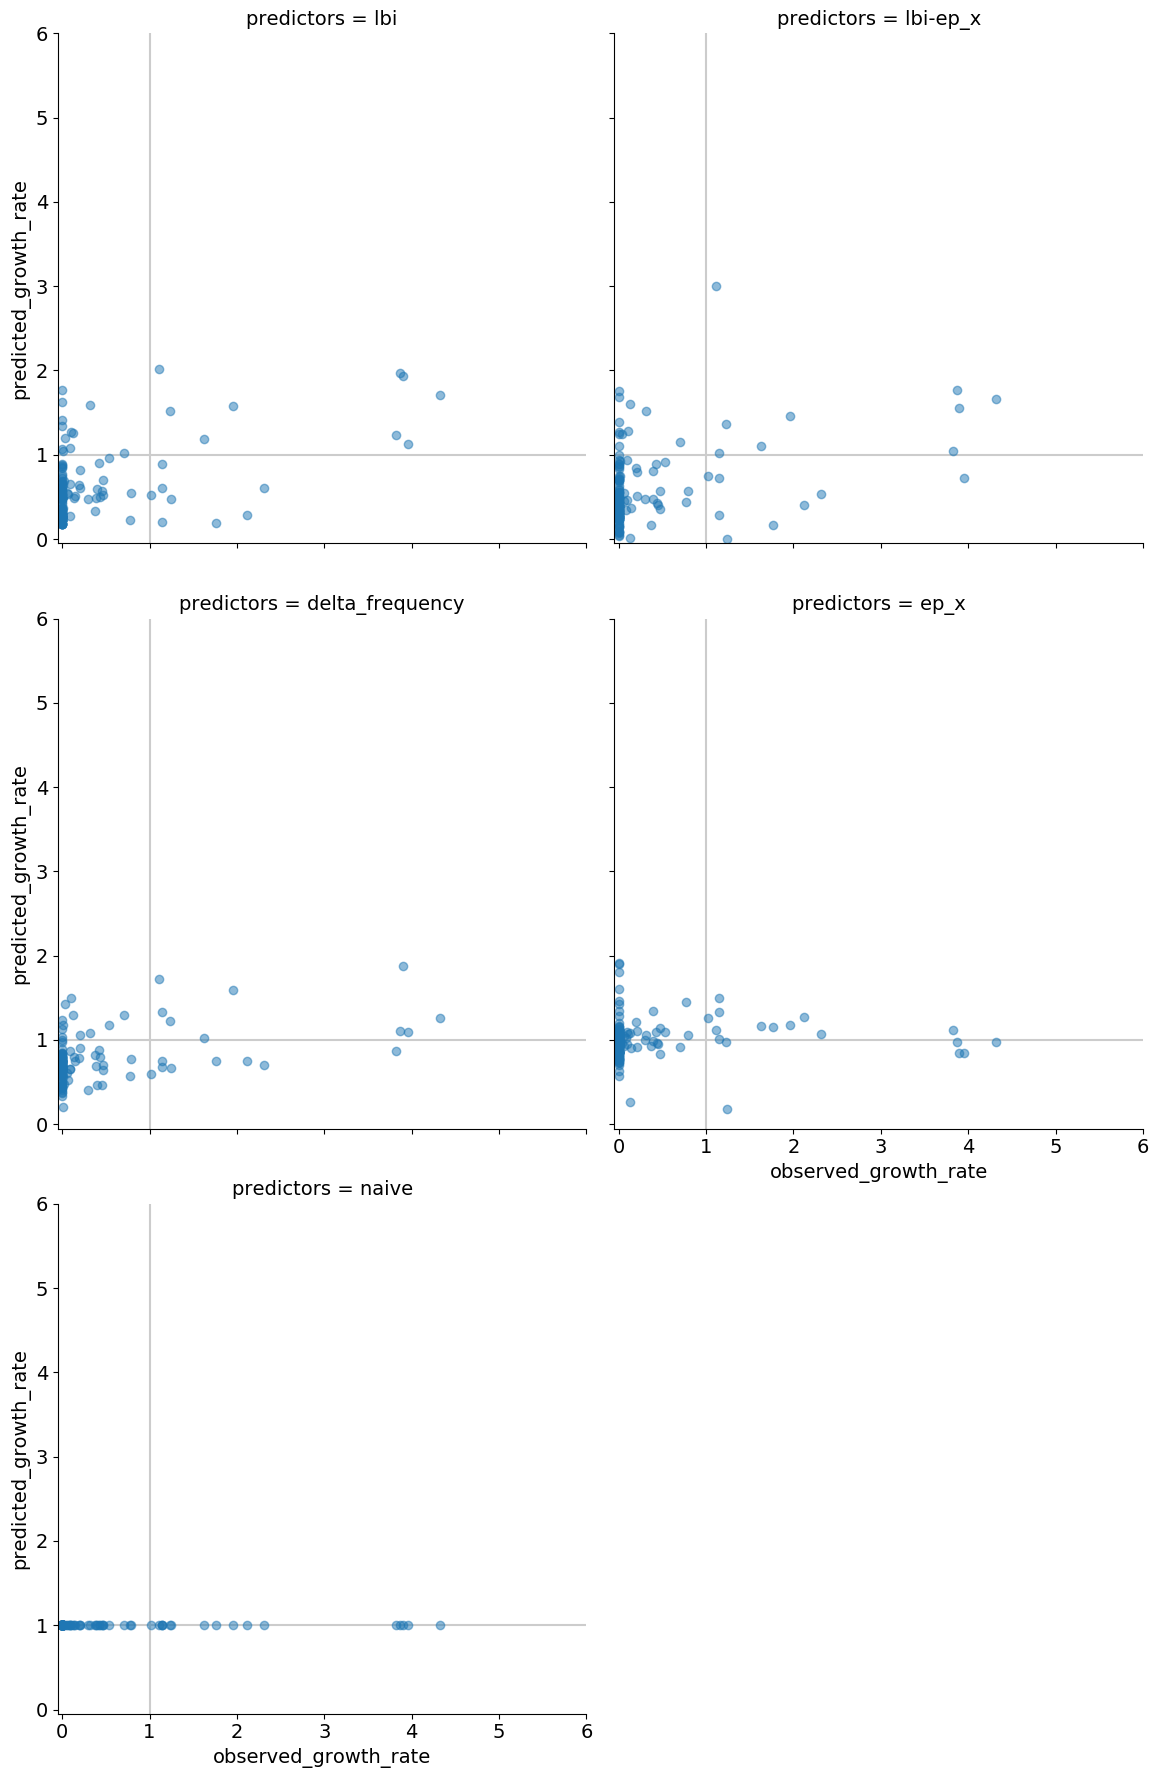

In [116]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

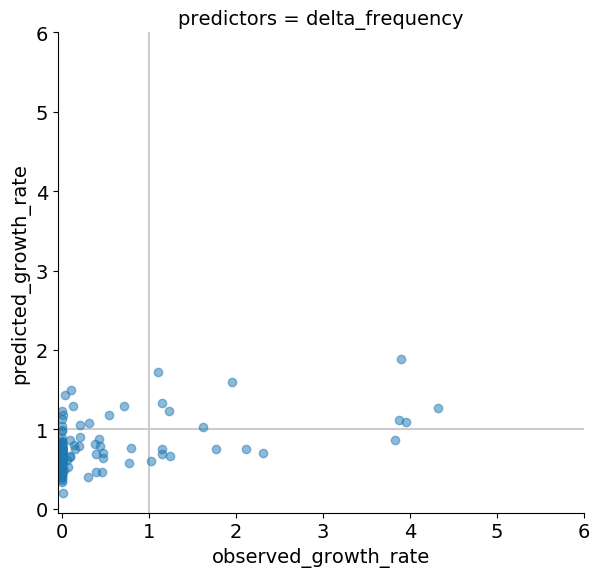

In [117]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

In [118]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,026d21f,0.003038,2011-10-01,0.000327,0.001722,0.002711,1.764228,0.190037,2011-10-01,lbi
1,05daa66,0.000000,2011-10-01,0.001647,0.005476,-0.001647,0.000000,0.300748,2011-10-01,lbi
2,15db5d7,0.000000,2011-10-01,0.002696,0.015034,-0.002696,0.000000,0.179337,2011-10-01,lbi
3,1f55924,0.000000,2011-10-01,0.000468,0.002684,-0.000468,0.000000,0.174494,2011-10-01,lbi
4,24fc224,0.000000,2011-10-01,0.000712,0.004075,-0.000712,0.000000,0.174784,2011-10-01,lbi


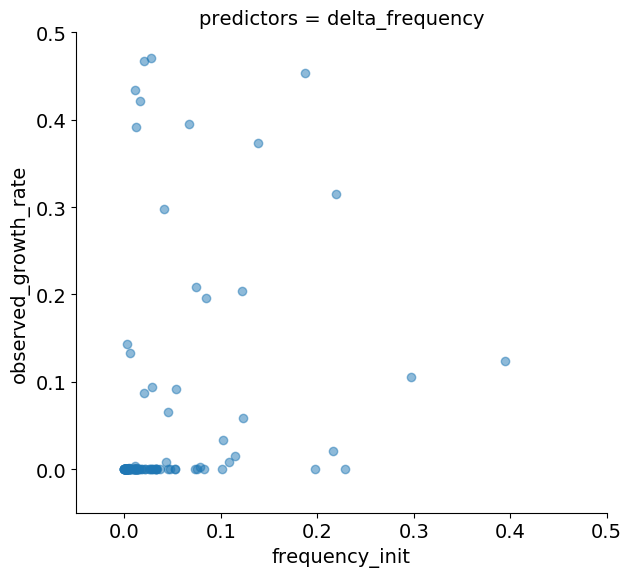

In [119]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "frequency_init", "observed_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 0.5)
    ax.set_ylim(-0.05, 0.5)

In [120]:
frequency_df.loc[frequency_df["observed_growth_rate"].idxmax()]

clade_membership                     bc4cbe3
frequency                           0.002049
timepoint                2014-04-01 00:00:00
frequency_hat                    2.05354e-06
frequency_init                         6e-06
residual                          0.00204695
observed_growth_rate                   341.5
predicted_growth_rate               0.342257
validation_timepoint     2014-04-01 00:00:00
predictors                               lbi
Name: 121, dtype: object

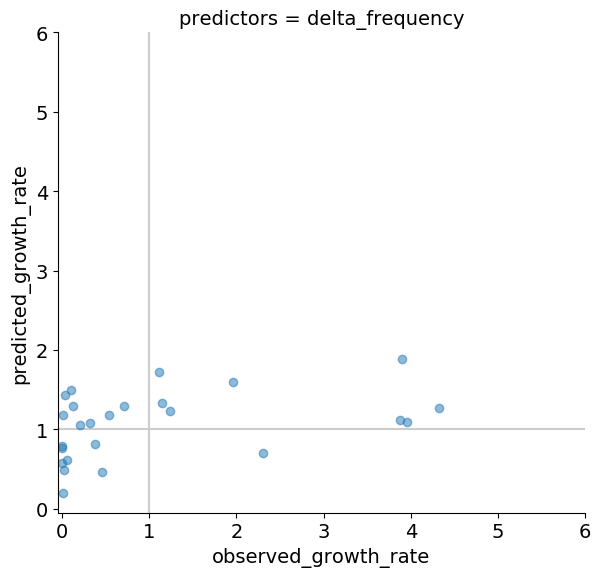

In [121]:
g = sns.FacetGrid(frequency_df[(frequency_df["predictors"] == "delta_frequency") & (frequency_df["frequency_init"] > 0.1)], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

## Summarize model forecasting error

### Mean absolute error (MAE)

In [122]:
mae_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [123]:
mae_df.sort_values("mae")

,predictors,mae
2,lbi,0.047165
0,delta_frequency,0.050051
3,lbi-ep_x,0.051623
4,naive,0.054986
1,ep_x,0.055132


In [124]:
mae_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [125]:
mae_by_timepoint_df.head()

,predictors,validation_timepoint,mae
0,delta_frequency,2011-10-01,0.039518
1,delta_frequency,2012-04-01,0.063727
2,delta_frequency,2012-10-01,0.044626
3,delta_frequency,2013-04-01,0.036886
4,delta_frequency,2013-10-01,0.050914


In [126]:
naive_mae = mae_by_timepoint_df[mae_by_timepoint_df["predictors"] == "naive"]["mae"].values
for predictor in mae_by_timepoint_df["predictors"].drop_duplicates().values:
    mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "adjusted_mae"] =  mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "mae"] - naive_mae

In [127]:
mae_df["adjusted_mae"] = mae_df["mae"] - mae_df[mae_df["predictors"] == "naive"]["mae"].iloc[0]

(0, 0.05619107140030811)

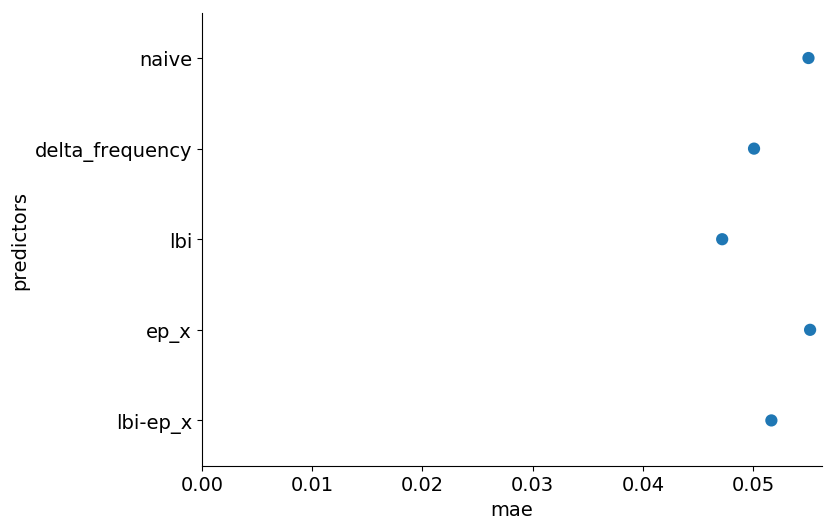

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

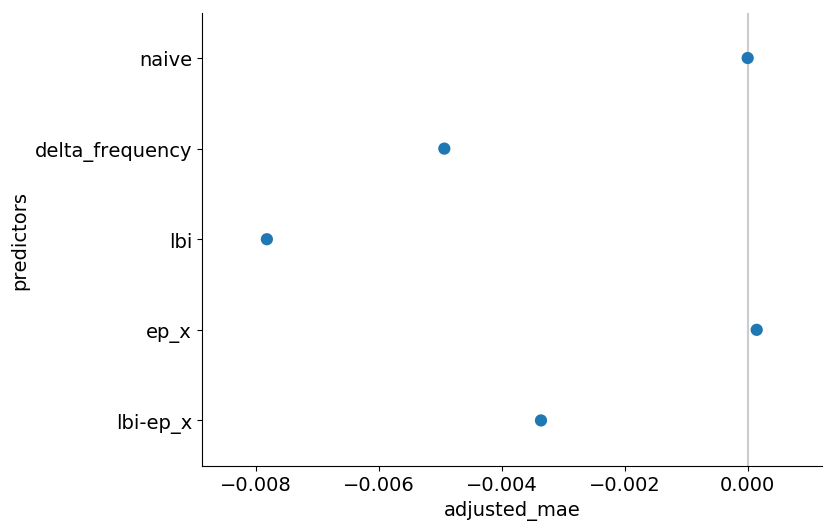

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="adjusted_mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

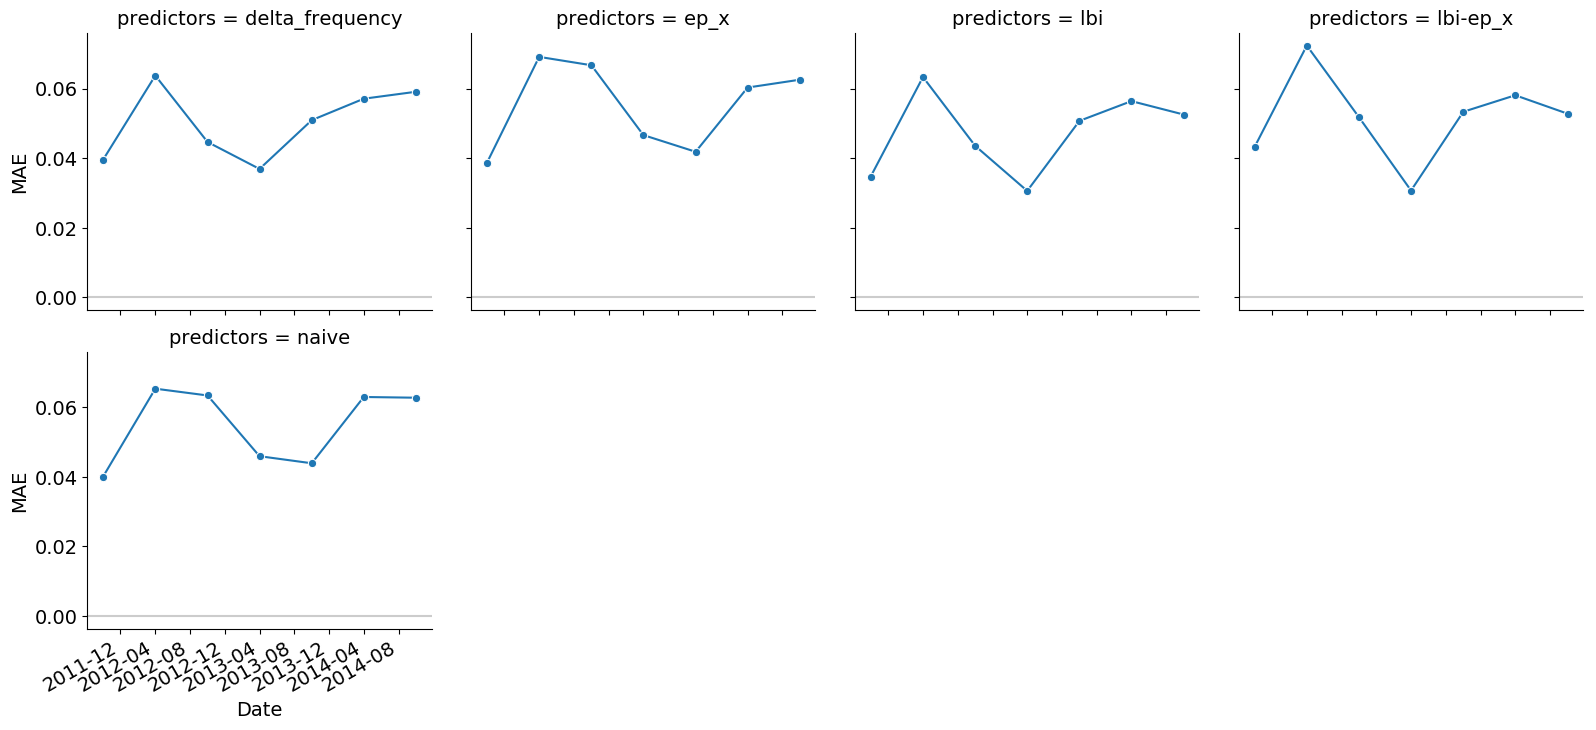

In [130]:
g = facet_time_plot(mae_by_timepoint_df, "mae", "MAE", timepoint_column="validation_timepoint")

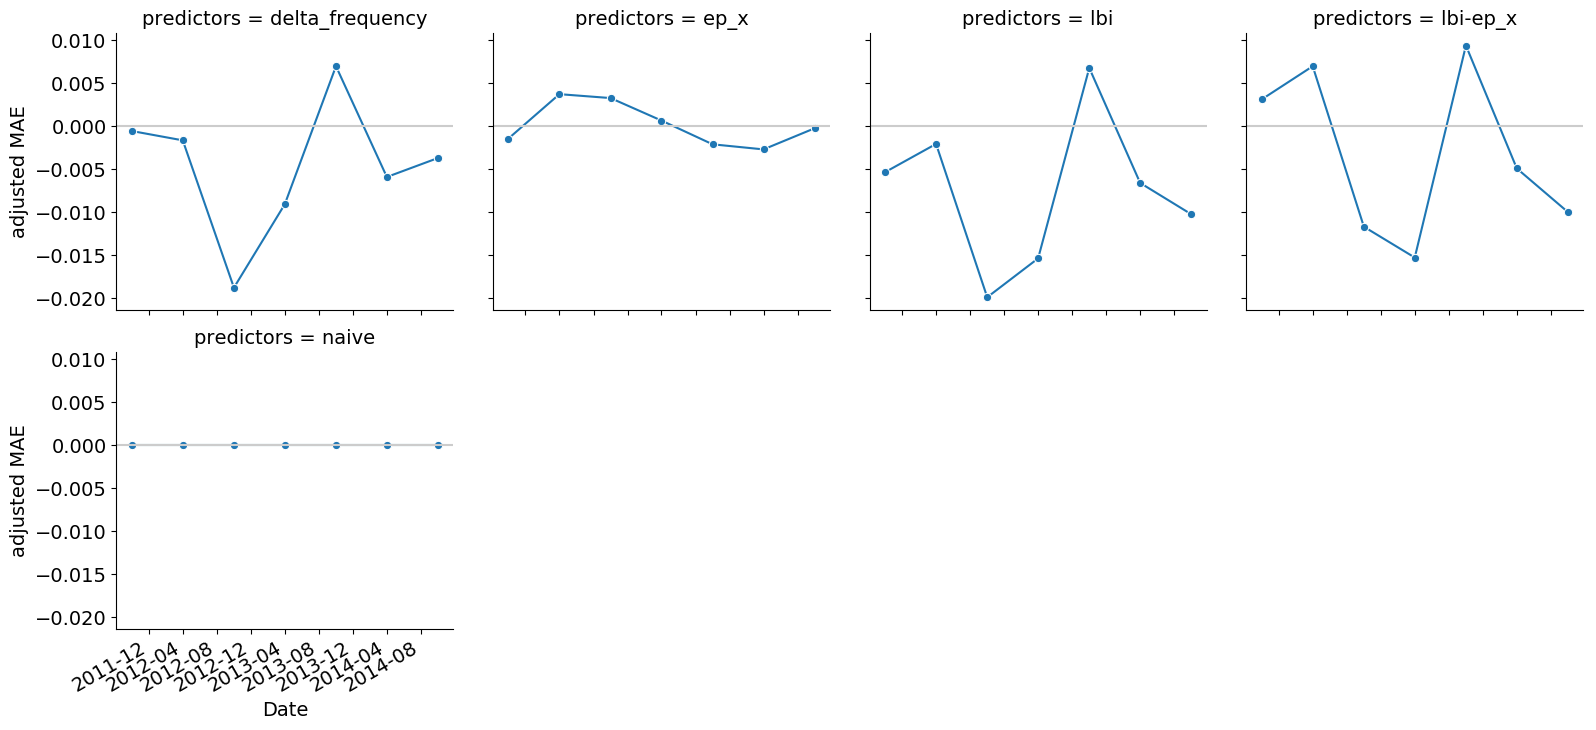

In [131]:
g = facet_time_plot(mae_by_timepoint_df, "adjusted_mae", "adjusted MAE", timepoint_column="validation_timepoint")

### Root mean square error (RMSE)

In [132]:
rmse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: root_mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "rmse"})

In [133]:
rmse_df.sort_values("rmse")

,predictors,rmse
2,lbi,0.118934
0,delta_frequency,0.126689
4,naive,0.131908
3,lbi-ep_x,0.134379
1,ep_x,0.135313


In [134]:
rmse_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: root_mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "rmse"})

In [135]:
naive_rmse = rmse_by_timepoint_df[rmse_by_timepoint_df["predictors"] == "naive"]["rmse"].values
for predictor in rmse_by_timepoint_df["predictors"].drop_duplicates().values:
    rmse_by_timepoint_df.loc[rmse_by_timepoint_df["predictors"] == predictor, "adjusted_rmse"] =  rmse_by_timepoint_df.loc[rmse_by_timepoint_df["predictors"] == predictor, "rmse"] - naive_rmse

In [136]:
rmse_df["adjusted_rmse"] = rmse_df["rmse"] - rmse_df[rmse_df["predictors"] == "naive"]["rmse"].iloc[0]

(0, 0.13679187199748313)

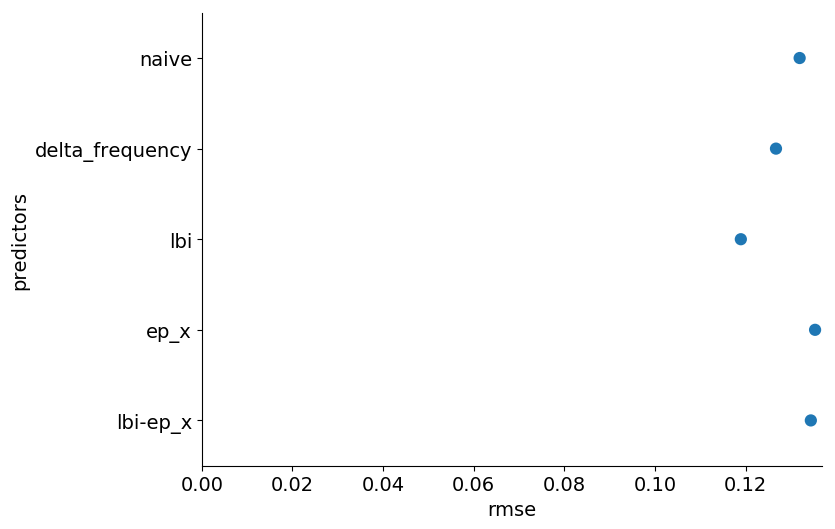

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="rmse",
    y="predictors",
    data=rmse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

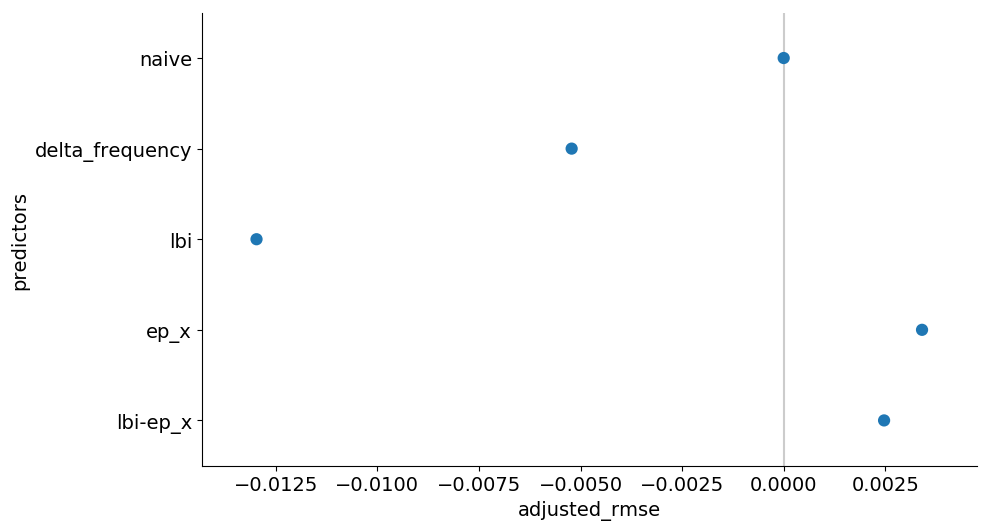

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.pointplot(
    x="adjusted_rmse",
    y="predictors",
    data=rmse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

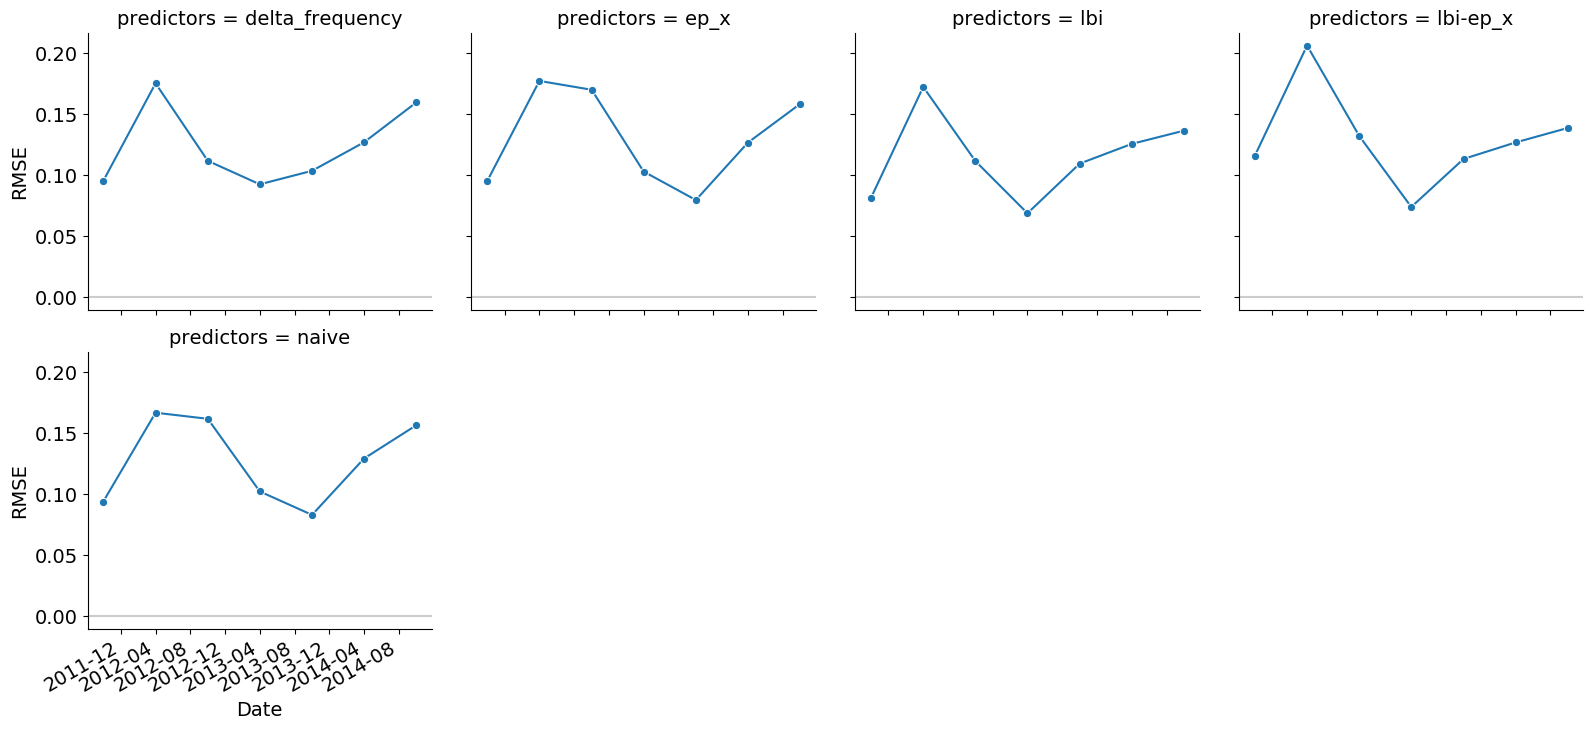

In [139]:
g = facet_time_plot(rmse_by_timepoint_df, "rmse", "RMSE", timepoint_column="validation_timepoint")

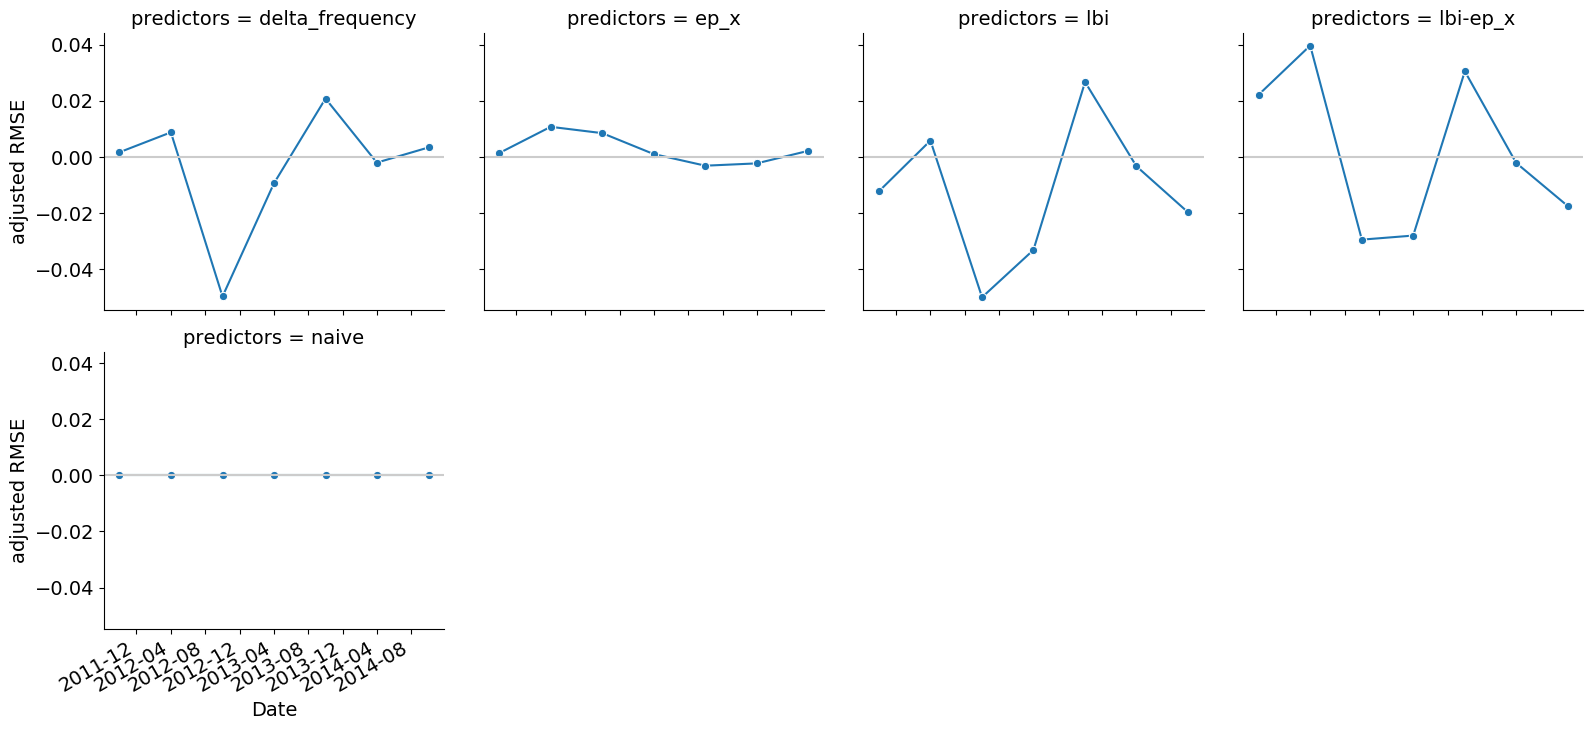

In [140]:
g = facet_time_plot(rmse_by_timepoint_df, "adjusted_rmse", "adjusted RMSE", timepoint_column="validation_timepoint")

### Mean squared error (MSE)

In [141]:
mse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [142]:
mse_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [143]:
naive_mse = mse_by_timepoint_df[mse_by_timepoint_df["predictors"] == "naive"]["mse"].values
for predictor in mse_by_timepoint_df["predictors"].drop_duplicates().values:
    mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "adjusted_mse"] =  mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "mse"] - naive_mse

(0, 0.01917810588297148)

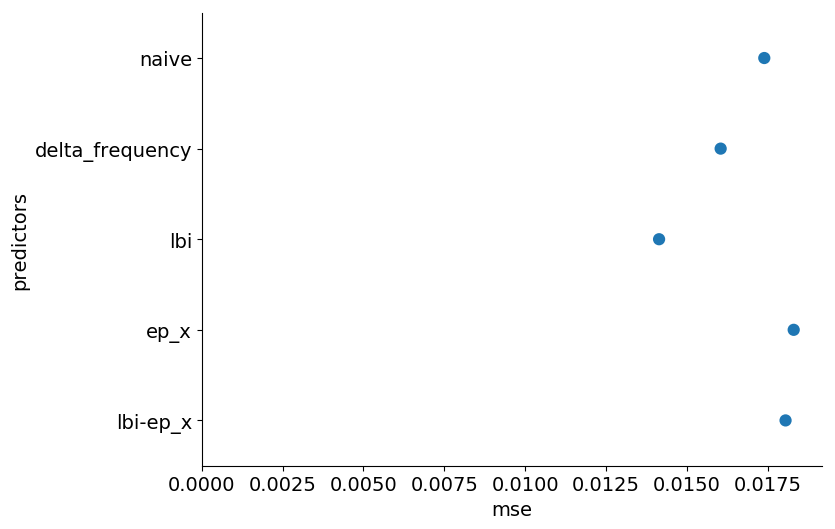

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mse",
    y="predictors",
    data=mse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

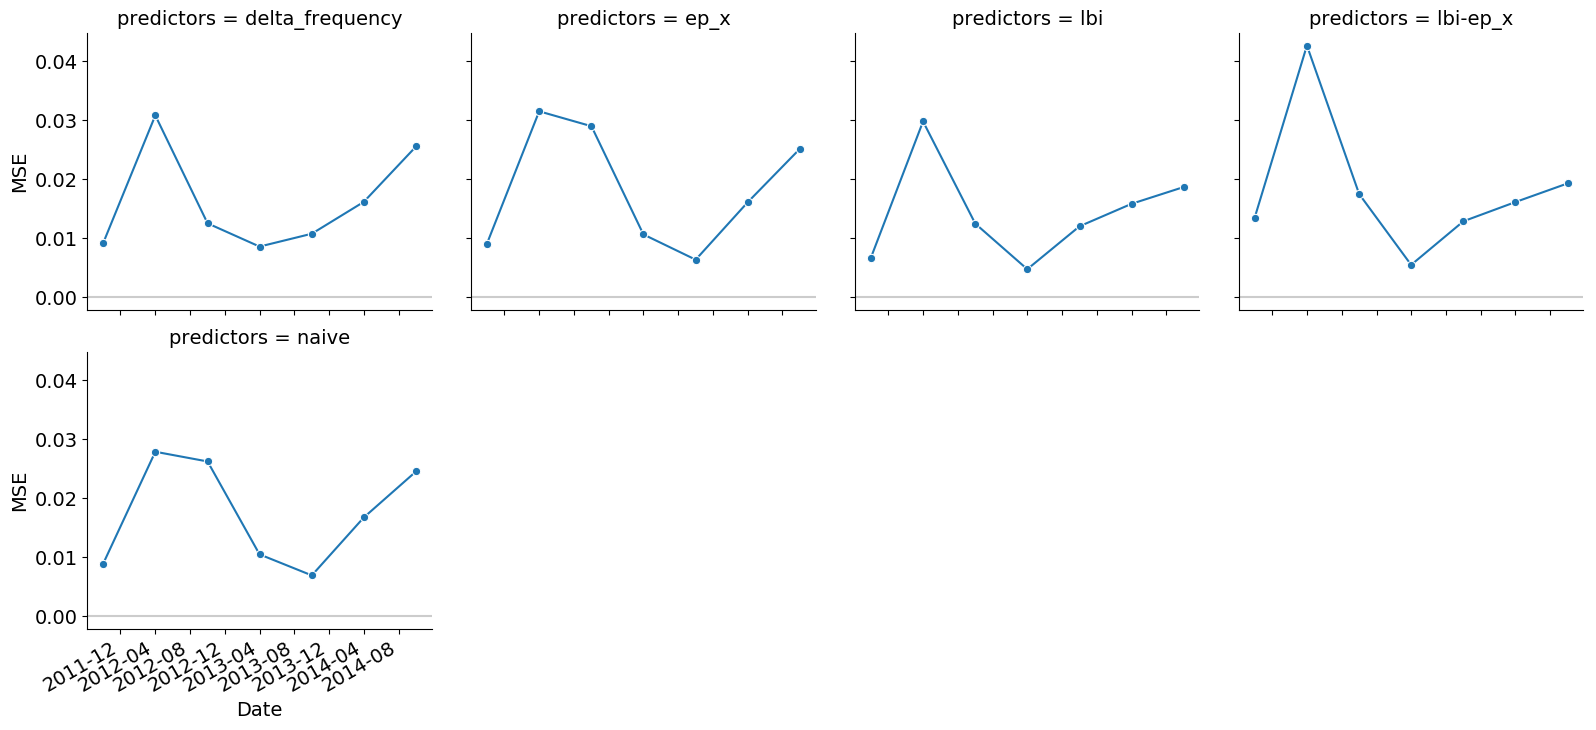

In [145]:
g = facet_time_plot(mse_by_timepoint_df, "mse", "MSE", timepoint_column="validation_timepoint")

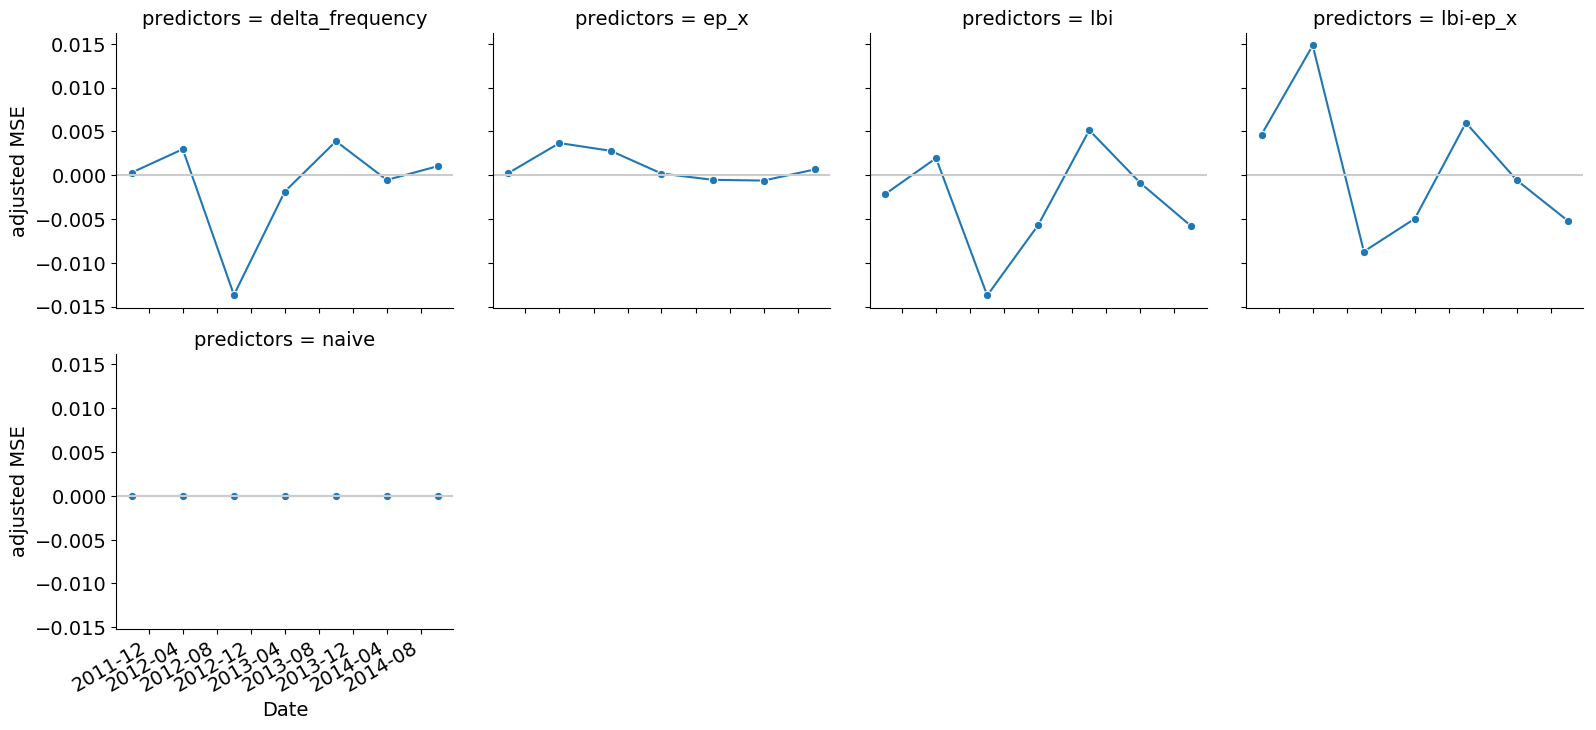

In [146]:
g = facet_time_plot(mse_by_timepoint_df, "adjusted_mse", "adjusted MSE", timepoint_column="validation_timepoint")

(0.0, 0.04478968009796673)

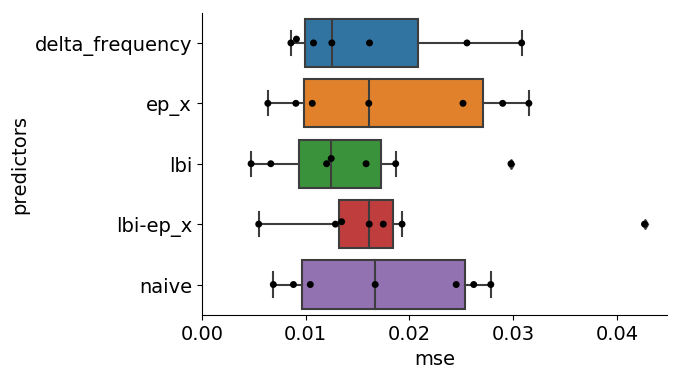

In [147]:
ax = sns.boxplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df
)
ax = sns.swarmplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df,
    color="black",
    ax=ax
)
ax.set_xlim(left=0.0)

## Summarize model coefficients

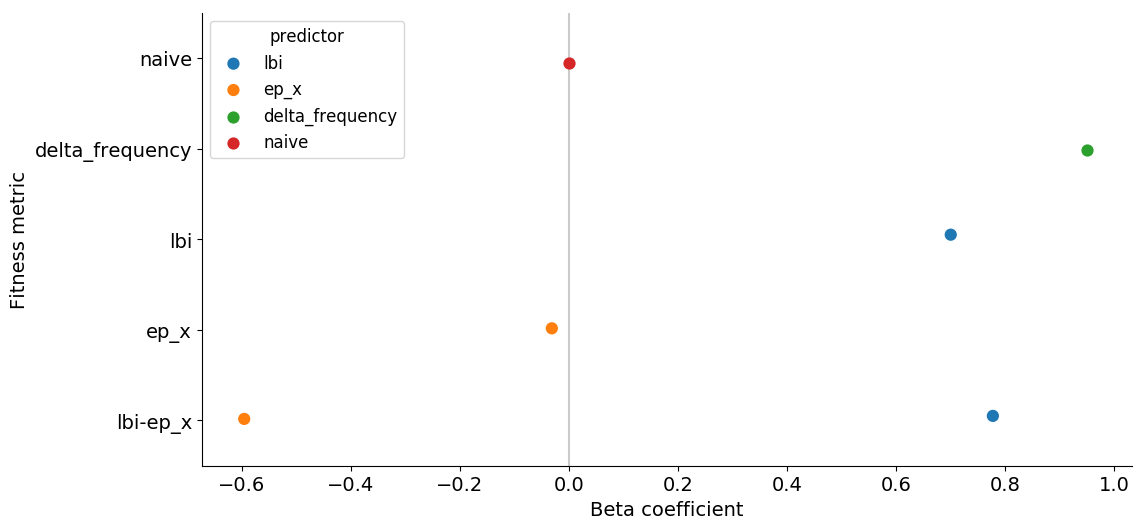

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False,
    order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [149]:
overall_coefficients_df

,mean,predictor,predictors,std
0,0.700066,lbi,lbi,0.127512
1,0.777326,lbi,lbi-ep_x,0.129134
2,-0.595686,ep_x,lbi-ep_x,0.527413
3,0.949051,delta_frequency,delta_frequency,0.182009
4,-0.031530,ep_x,ep_x,0.334938
5,0.000000,naive,naive,0.000000


In [150]:
coefficients_by_time_df.head()

,coefficient,predictor,predictors,validation_timepoint
0,0.820906,lbi,lbi,2011-10-01
1,0.481122,lbi,lbi,2012-04-01
2,0.549643,lbi,lbi,2012-10-01
3,0.703240,lbi,lbi,2013-04-01
4,0.806088,lbi,lbi,2013-10-01


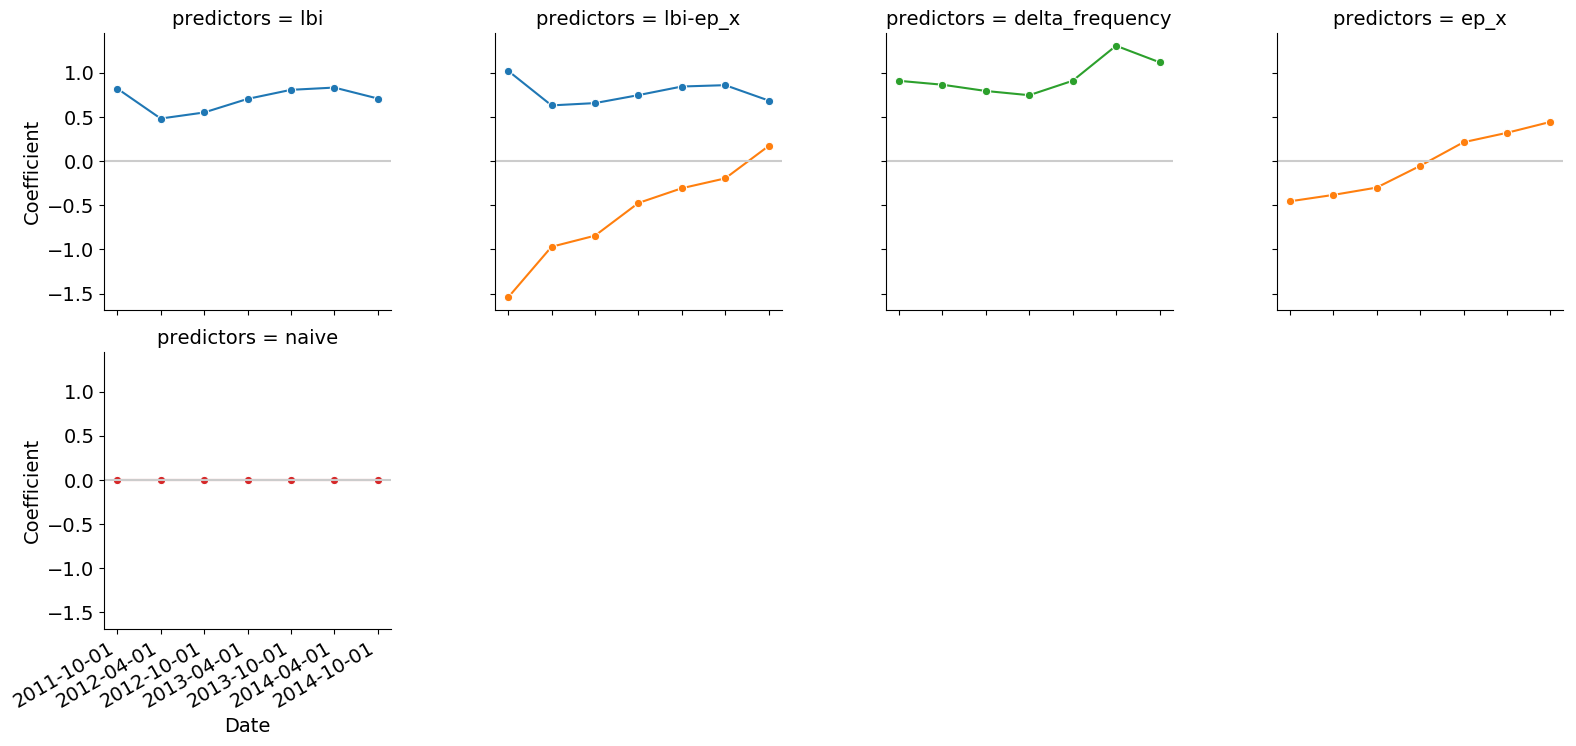

In [151]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")

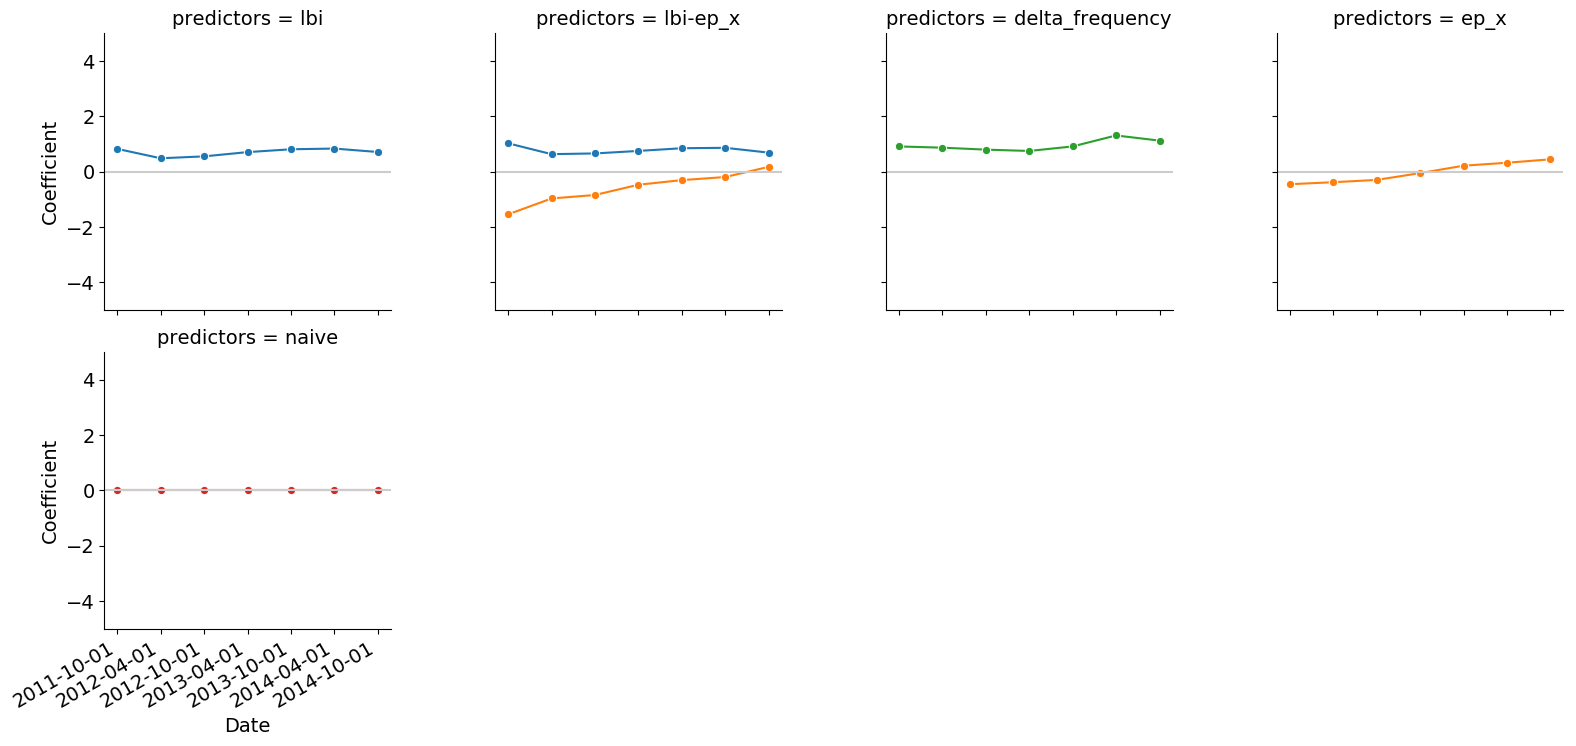

In [152]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")

for ax in g.axes.flatten():
    ax.set_ylim(-5, 5)